<h1 style = 'color: orange'> Taxi Company - Crazy Run - S13  </h1>

A empresa Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. 

Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 

Construa um modelo para tal predição.

Diretrizes:

-   Faça download dos dados e faça uma nova amostragem deles de forma que cada ponto dos dados originais fique dentro de intervalos de uma hora;
-   Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial;
-   A métrica REQM no conjunto de teste não deve ser superior a 48;
-   Teste os dados usando a amostra de teste e forneça uma conclusão.

<h2 style = 'color: orange'> Initialization  </h2>

In [26]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

from scipy import stats as st

import math

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import textwrap

sns.set_theme(style="whitegrid")

from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.linear_model

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

from numpy.linalg import LinAlgError

from IPython.display import display

from catboost import CatBoostRegressor

import time

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


<h2 style = 'color: orange'> Reading Files:</h2>

In [27]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [28]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [30]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<h2 style = 'color: orange'> Data preprocessing:</h2>

In [31]:
df.sort_index(inplace=True)

In [32]:
df.index.is_monotonic_increasing

True

In [33]:
# Resampling the data (for each hour).

df_hour = df.resample('1H').sum()

In [34]:
df_hour

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


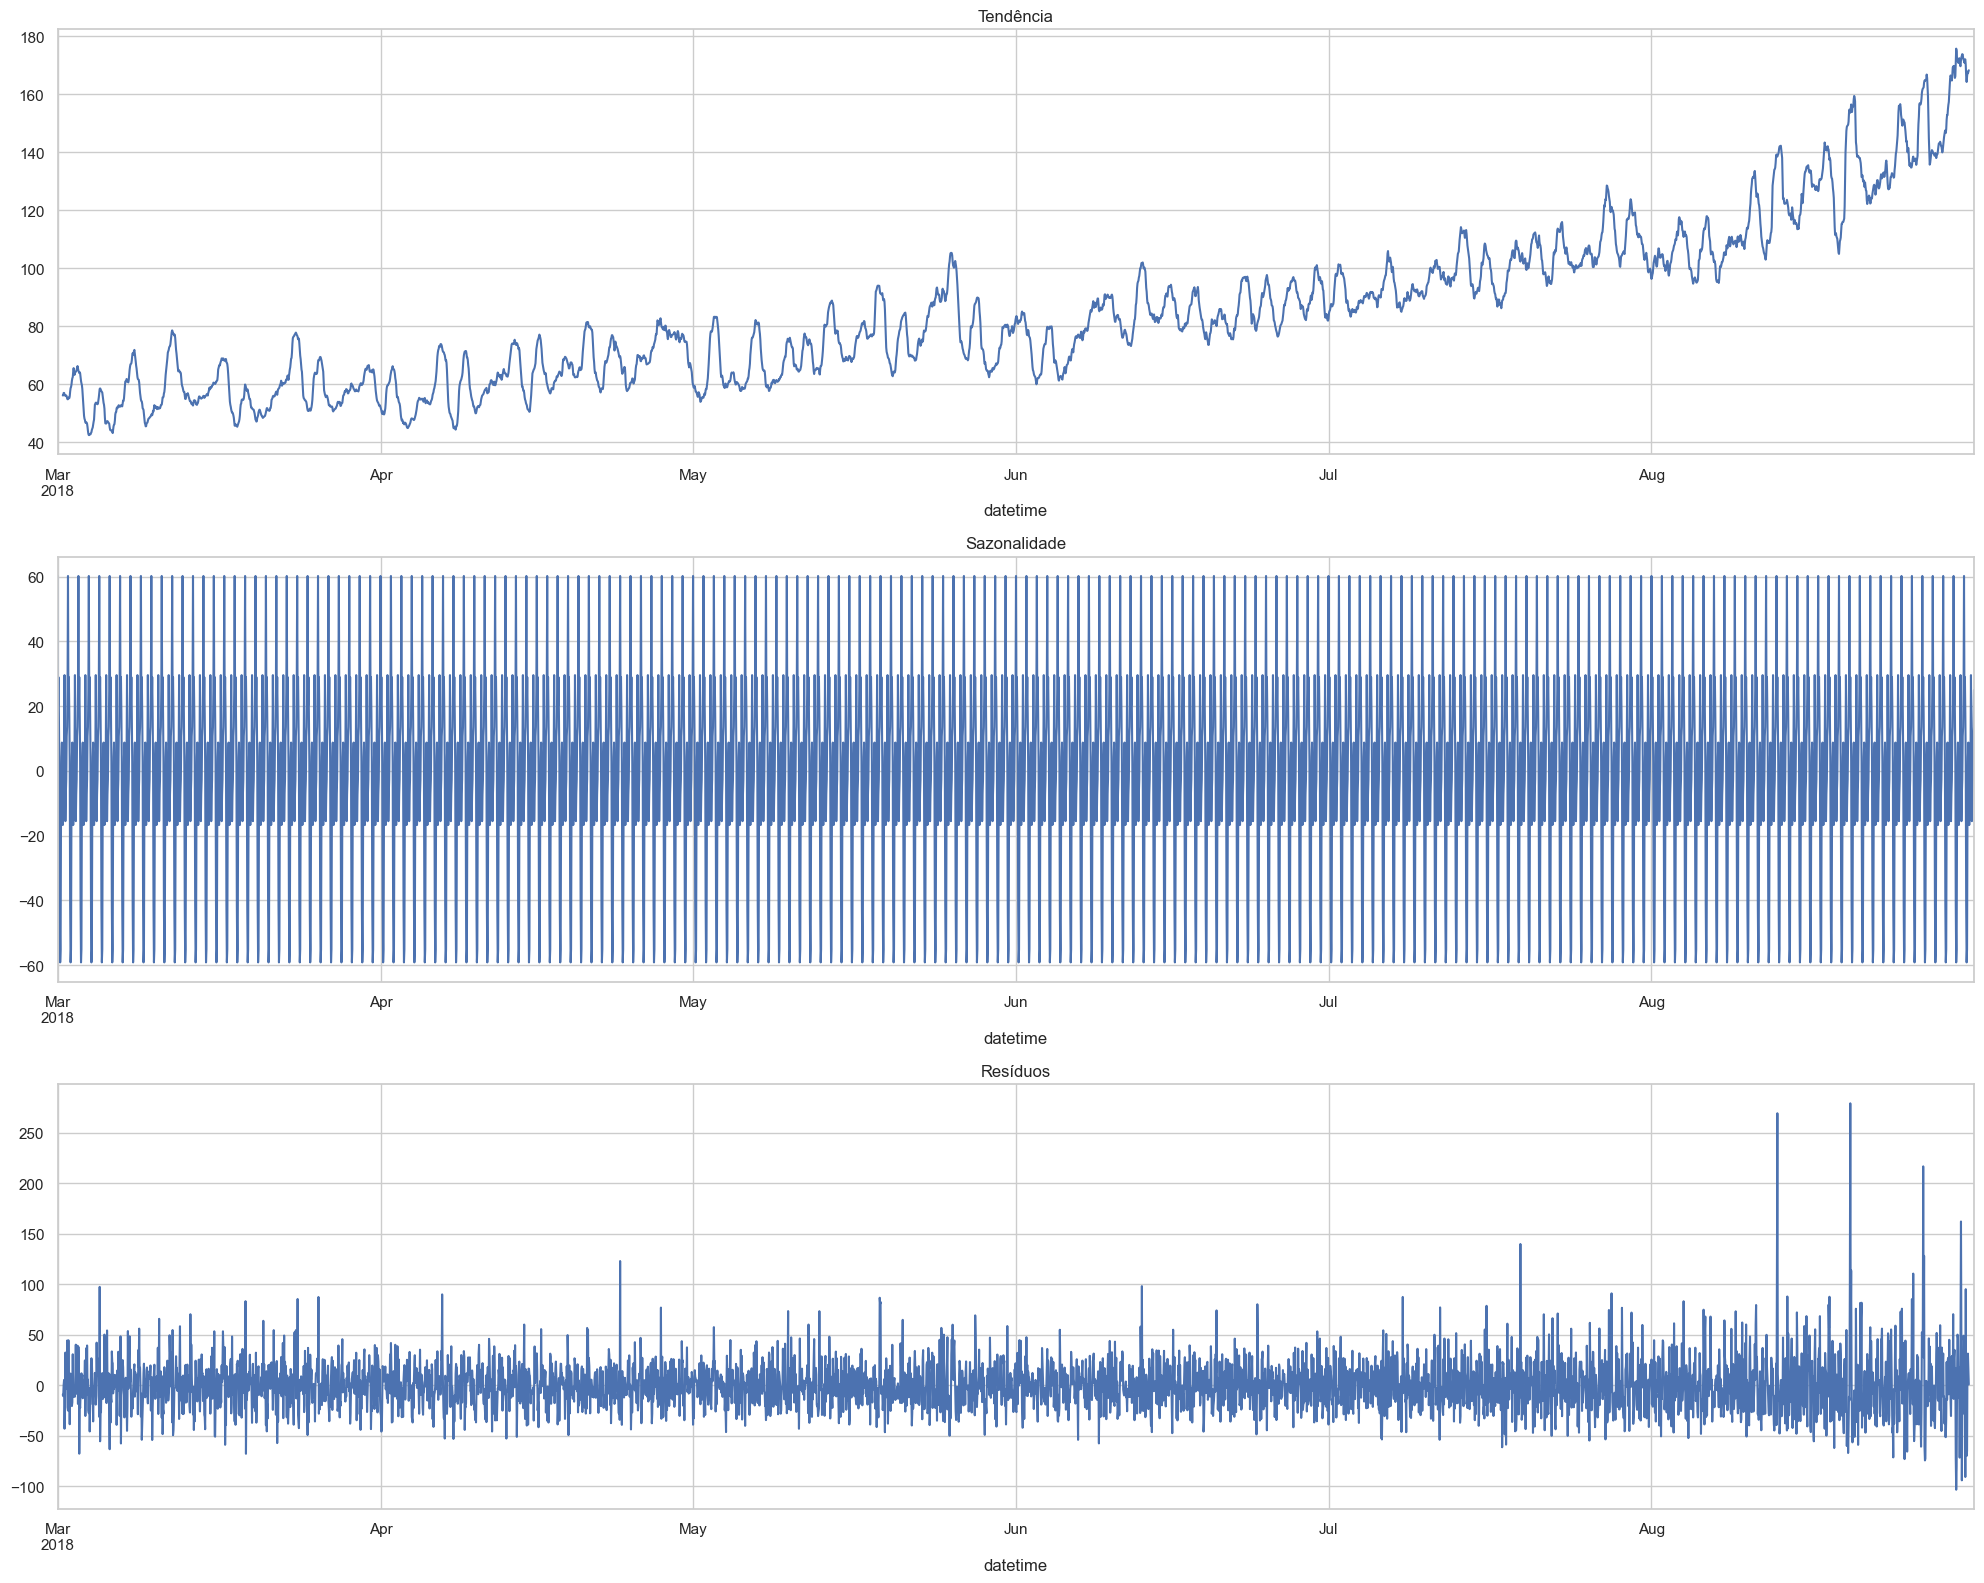

In [35]:
# Analyzing trend, seasonality and resid:

decomposed = seasonal_decompose(df_hour['num_orders'])

plt.figure(figsize=(20, 16))

plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')

plt.tight_layout()

Destaco dos gráficos a tendência de crescimento no número de pedidos e a quantidade de ruídos que terá que ser tratada para viabilizar um modelo com bom desempenho.

In [36]:
# Including columns for residual treatments:

result = seasonal_decompose(df_hour['num_orders'], model='additive', period=24)

df_hour['trend'] = result.trend
df_hour['seasonal'] = result.seasonal
df_hour['residual'] = result.resid

In [37]:
df_hour.isna().mean()

num_orders    0.000000
trend         0.005435
seasonal      0.000000
residual      0.005435
dtype: float64

In [38]:
df_hour = df_hour.dropna()

In [39]:
# Define function to identify and replace outliers based on trend and seasonality:

def replace_outliers(data, residual_col='residual', trend_col='trend', seasonal_col='seasonal', threshold=3):
    
    residuals = data[residual_col]
    trend = data[trend_col]
    seasonal = data[seasonal_col]
    
    mean_residual = residuals.mean()
    std_residual = residuals.std()
    
    outliers = (residuals - mean_residual).abs() > threshold * std_residual
    
    num_altered = outliers.sum()
    
    data.loc[outliers, 'num_orders'] = trend[outliers] + seasonal[outliers]
    
    return data, num_altered


df_hour, num_altered = replace_outliers(df_hour)

print(f'Number of lines changed: {num_altered}')

Number of lines changed: 46


O tratamento dos outliers baseados na média e desvio padrão dos resíduos tratou dados de 46 linhas do DF. É um percentual pequeno, porém são dados que durante a execução do modelo podem elevar o valor do RMSE prejudicando a avaliação do desempenho.

In [40]:
df_hour.isna().mean()

num_orders    0.0
trend         0.0
seasonal      0.0
residual      0.0
dtype: float64

<h2 style = 'color: orange'> ML - SARIMA:</h2>

In [41]:
# Applying the Augmented Dickey-Fuller test

result = adfuller(df_hour['num_orders'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.9459222084985095
p-value: 0.0402625692291055


Como o valor-p (0,0403) é menor que 0,05, a hipótese nula de que existe uma raiz unitária na série temporal com 95% de confiança, é rejeitada. Isso indica que a série é estacionária ao nível de significância de 5%.

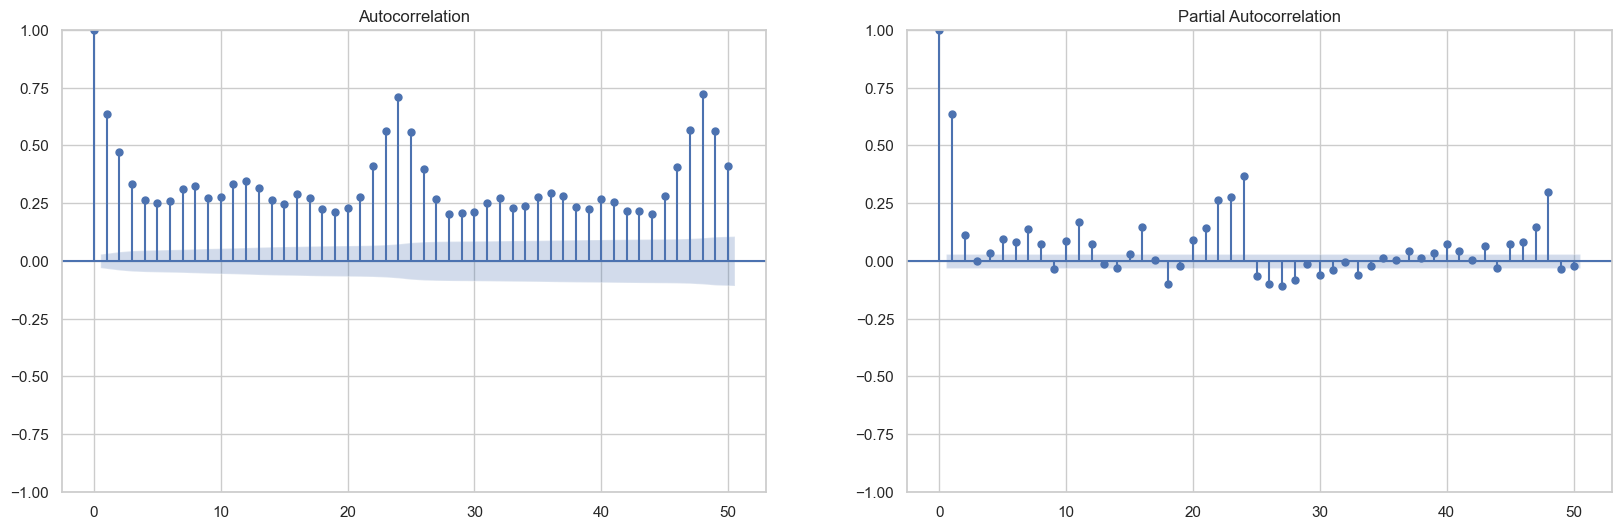

In [42]:
# Plotting ACF and PACF:

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plot_acf(df_hour['num_orders'], lags=50, ax=axes[0])
plot_pacf(df_hour['num_orders'], lags=50, ax=axes[1])
plt.show()

In [43]:
df_hour.head()

,num_orders,trend,seasonal,residual
datetime,,,,
2018-03-01 12:00:00,30.0,56.125000,-16.721606,-9.403394
2018-03-01 13:00:00,32.0,56.145833,-13.352412,-10.793422
2018-03-01 14:00:00,48.0,56.958333,-9.191665,0.233331
2018-03-01 15:00:00,66.0,57.000000,3.731832,5.268168
2018-03-01 16:00:00,43.0,56.479167,29.604100,-43.083267


In [44]:
# Resetting the DataFrame:

df_hour = df_hour[['num_orders']]

In [45]:
# Splitting the data:

train_size = int(len(df_hour) * 0.8)
val_size = int(len(df_hour) * 0.1)
test_size = len(df_hour) - train_size - val_size

train = df_hour[:train_size]
val = df_hour[train_size:train_size + val_size]
test = df_hour[train_size + val_size:]

In [50]:
# Adjusting the SARIMA model:

p, d, q = 1, 1, 2   
P, D, Q, s = 1, 1, 1, 24  

model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)


# Making predictions for the validation set:

val_predictions = model_fit.get_forecast(steps=len(val)).predicted_mean


# Fitting the SARIMA model again including the validation data:

model = SARIMAX(pd.concat([train, val]), order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)


# Making predictions for the test set:

test_predictions = model_fit.get_forecast(steps=len(test)).predicted_mean


# Evaluating the model on the validation set:

mse_val = mean_squared_error(val, val_predictions)
rmse_val = np.sqrt(mse_val)
print("RMSE (Validação):", rmse_val)


# Evaluating the model on the test set:

mse_test = mean_squared_error(test, test_predictions)
rmse_test = np.sqrt(mse_test)
print("RMSE (Teste):", rmse_test)


RMSE (Validação): 26.025363996810825
RMSE (Teste): 33.429009608558765


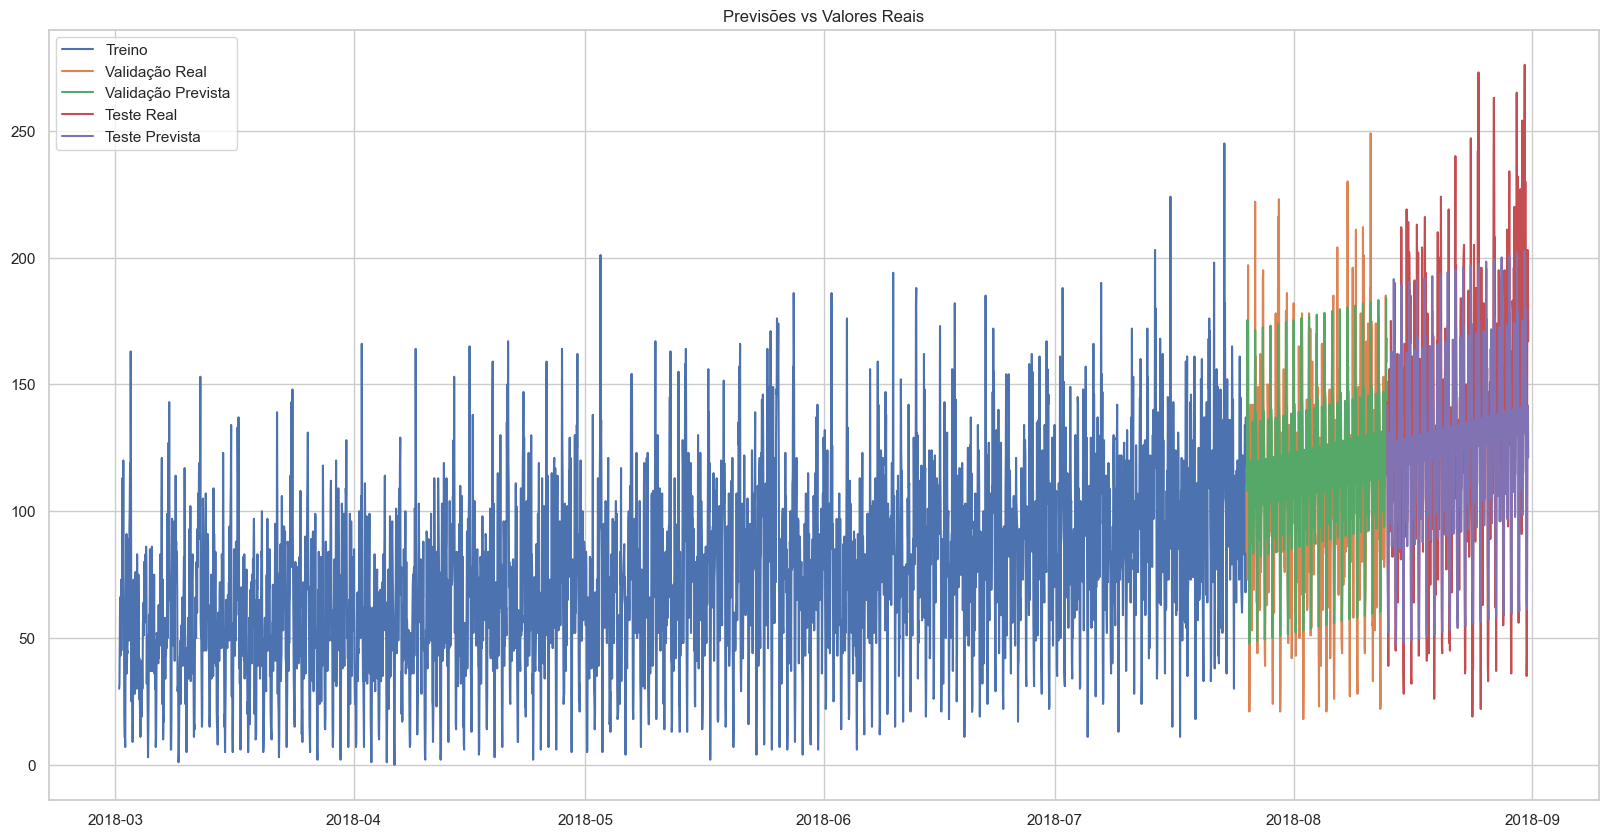

In [47]:
# Plotting predictions versus actual values:

plt.figure(figsize=(20, 10))


# Plotting training data:

plt.plot(train.index, train, label='Treino')


# Plotting validation data and its predictions:

plt.plot(val.index, val, label='Validação Real')
plt.plot(val.index, val_predictions, label='Validação Prevista')


# Plotting test data and its predictions:

plt.plot(test.index, test, label='Teste Real')
plt.plot(test.index, test_predictions, label='Teste Prevista')

plt.title('Previsões vs Valores Reais')
plt.legend()
plt.show()

<h2 style = 'color: orange'> Conclusions:</h2>

A substituição dos modelos anteriormente usados para essa tarefa pelo SARIMA, possibilitou resultados melhores.

Modelos como o SARIMA, desenvolvidos especificamente para esse tipo de trabalho, costumam ser mais eficientes do que modelos mais generalistas.
